In [6]:
import os
import time
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy as sp
from mri.operators import FFT,WaveletN, OWL
from modopt.opt.proximity import GroupLASSO, IdentityProx

from online.generators.column import Column2DKspaceGenerator,  DataOnlyKspaceGenerator
from online.reconstructors.fast import OnlineReconstructor
from online.operators.fourier import ColumnFFT
from utils import implot, load_data, create_cartesian_metrics
from online.metrics import crop_center_square, ssos

(16, 640, 320) complex128
(320, 320) float32
file_brain_AXFLAIR_200_6002462.h5
1


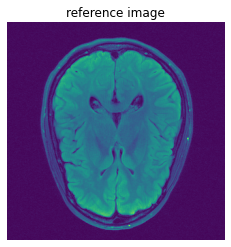

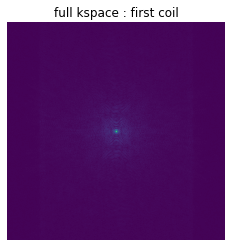

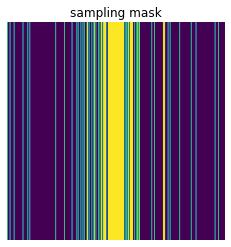

In [7]:
DATA_DIR = "../data/"
RESULT_DIR = "../data/results/"
N_JOBS = 1
results = dict()

full_k, real_img, mask_loc, final_mask = load_data(DATA_DIR,1)
# use mono-coil data
full_k = sp.fft.ifftshift(sp.fft.fft2(real_img,s=(320,320),norm="ortho"))
final_mask = crop_center_square(final_mask)
final_k = full_k * final_mask
implot(real_img, "reference image")
implot(np.sqrt(np.abs(full_k)), "full kspace : first coil")
implot(final_mask, "sampling mask")


# Type I reconstruction

In [8]:
kspace_gen = Column2DKspaceGenerator(final_k,mask_cols=mask_loc)
K_DIM = kspace_gen.shape[-2:]
N_COILS = kspace_gen.shape[0] if full_k.ndim == 3 else 1
# The fourier Operator apply also the sampling mask.
fourier_op = FFT(shape=K_DIM,n_coils=N_COILS, mask=final_mask)
# Wavelets coefficients for each coils
linear_op = WaveletN("sym8", nb_scale=4, n_coils=N_COILS, n_jobs=N_JOBS)
# initialisation of wavelet transform
linear_op.op(np.zeros_like(final_k))

# Regularizer definition
GL_op = GroupLASSO(weights = 1e-3)
OWL_op = OWL(alpha=1e-05,
             beta=1e-12,
             bands_shape=linear_op.coeffs_shape,
             mode='band_based',
             n_coils=N_COILS,
             n_jobs=N_JOBS)
cost_op_kwargs = {'cost_interval': 1}

x_w = linear_op.op(real_img)
x_wreg = OWL_op.op(x_w)
x_reg = linear_op.adj_op(x_wreg)

In [9]:
online_pb = OnlineReconstructor(fourier_op,
                                linear_op,
                                regularizer_op=OWL_op,
                                grad_formulation='analysis',
                                verbose=1)

metrics = create_cartesian_metrics(online_pb, real_img, final_k, final_mask)

# xf, costs, metrics_results = online_pb.reconstruct(kspace_gen,
#                                                    optimization_alg='condatvu',
#                                                    cost_op_kwargs=cost_op_kwargs,
#                                                    metrics=metrics,
#                                                    metric_call_period=1,
#                                                    )
# implot(ssos(xf))
# plt.plot(costs)
# plt.title('online cost')
# plt.xlabel('iterations')

Lipschitz constant is 1.1


# Grid Search

In [10]:
import itertools
def product_dict(**kwargs):
    for keys in kwargs.keys():
        if type(kwargs[keys]) not in [list, tuple, np.ndarray]:
            kwargs[keys] = [kwargs[keys]]
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in itertools.product(*vals):
        yield dict(zip(keys, instance))

def key_val(**kwargs):
    st = ""
    for k, v in kwargs.items():
        if type(v) is str:
            st += v
        elif type(v) is float:
            st += f'{k}_{v:.2e}'
    return st
kspace_gen = Column2DKspaceGenerator(final_k,mask_cols=mask_loc)
K_DIM = kspace_gen.shape[-2:]
N_COILS = kspace_gen.shape[0] if full_k.ndim == 3 else 1
fourier_op = FFT(shape=K_DIM,n_coils=N_COILS, mask=final_mask)
linear_op = WaveletN("sym8", nb_scale=4, n_coils=N_COILS, n_jobs=N_JOBS)
linear_op.op(np.zeros_like(final_k))

from datetime import datetime

regs = [{'class': OWL,
        'kwargs': {'alpha': 1e-5,
                   'beta': 1e-12,
                   'mode': ['all','band_based',],
                   },
         'cst_kwargs':{
                   'bands_shape': linear_op.coeffs_shape.copy(),
                   'n_coils': N_COILS,
                   'n_jobs': N_JOBS,
        }},
        {'class': GroupLASSO,
        'kwargs': {'weights': 1e-4},
        'cst_kwargs': {}}]

algo = [{
        'opt':'condatvu',
        'grad_formulation':'analysis',
        'kwargs':{},
        },
        {
        'opt':'pogm',
        'grad_formulation':'synthesis',
        'kwargs':{}
        },
        {
        'opt':'vanilla',
        'grad_formulation':'analysis',
        'kwargs': {
            'eta': [1.0]
        }}]
idx = 0
for reg_config in regs:
  for reg_param in product_dict(**reg_config['kwargs']):
    for alg_config in algo:
      for alg_param in product_dict(**alg_config['kwargs']):
        idx +=1
print('total number of config:',idx)

for reg_config in regs:
  reg_cls = reg_config['class']
  for reg_param in product_dict(**reg_config['kwargs']):
    for alg_config in algo:
      prox_op = reg_cls(**reg_param, **reg_config['cst_kwargs'])
      online_pb = OnlineReconstructor(fourier_op,
                            linear_op,
                            regularizer_op=prox_op,
                            grad_formulation=alg_config['grad_formulation'],
                            verbose=0)
      for alg_param in product_dict(**alg_config['kwargs']):
        string = f'{reg_config["class"].__name__}-{key_val(**reg_param)}-{alg_config["opt"]}-{key_val(**alg_param)}'
        print(string)
        metrics = create_cartesian_metrics(online_pb, real_img, final_k, final_mask)
        xf, costs, metrics_results = online_pb.reconstruct(kspace_gen,
                                                   optimization_alg=alg_config['opt'],
                                                   metrics=metrics,
                                                   metric_call_period=1,
                                                   cost_op_kwargs={'cost_interval': 1},
                                                   **alg_param,
                                                   )
        #hack, should be defined cleaner within pysap
        struct = copy.deepcopy(metrics_results[list(metrics_results.keys())[0]])
        metrics_results['cost'] = struct
        metrics_results['cost']['values'] = costs
        results[string] = metrics_results

today = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
np.save(f'grid_search_{today}.npy',results)
print(today)

total number of config: 9
OWL-alpha_1.00e-05beta_1.00e-12all-condatvu-


  0%|          | 0/80 [00:00<?, ?it/s]/home/pac/.pyenv/versions/mri/lib/python3.9/site-packages/modopt/math/metrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  return (img - min_img) / (max_img - min_img)
81it [00:15,  5.26it/s]                        


OWL-alpha_1.00e-05beta_1.00e-12all-pogm-


  0%|          | 0/80 [00:00<?, ?it/s]/home/pac/.pyenv/versions/mri/lib/python3.9/site-packages/modopt/math/metrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  return (img - min_img) / (max_img - min_img)
81it [00:19,  4.06it/s]                        


OWL-alpha_1.00e-05beta_1.00e-12all-vanilla-eta_1.00e+00


  0%|          | 0/80 [00:00<?, ?it/s]/home/pac/.pyenv/versions/mri/lib/python3.9/site-packages/modopt/math/metrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  return (img - min_img) / (max_img - min_img)
81it [00:12,  6.74it/s]                        


OWL-alpha_1.00e-05beta_1.00e-12band_based-condatvu-


  0%|          | 0/80 [00:00<?, ?it/s]/home/pac/.pyenv/versions/mri/lib/python3.9/site-packages/modopt/math/metrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  return (img - min_img) / (max_img - min_img)
81it [00:15,  5.21it/s]                        


OWL-alpha_1.00e-05beta_1.00e-12band_based-pogm-


  0%|          | 0/80 [00:00<?, ?it/s]/home/pac/.pyenv/versions/mri/lib/python3.9/site-packages/modopt/math/metrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  return (img - min_img) / (max_img - min_img)
81it [00:23,  3.49it/s]                        


OWL-alpha_1.00e-05beta_1.00e-12band_based-vanilla-eta_1.00e+00


  0%|          | 0/80 [00:00<?, ?it/s]/home/pac/.pyenv/versions/mri/lib/python3.9/site-packages/modopt/math/metrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  return (img - min_img) / (max_img - min_img)
81it [00:12,  6.66it/s]                        


GroupLASSO-weights_1.00e-04-condatvu-


81it [00:10,  7.73it/s]                        


GroupLASSO-weights_1.00e-04-pogm-


81it [00:15,  5.37it/s]                        


GroupLASSO-weights_1.00e-04-vanilla-eta_1.00e+00


81it [00:08,  9.82it/s]                        


2021-05-21_14:36:08
